## MJPC Test with Motion Prediction

The aim of this test is to test motion prediction with manual injection of user data in mjpc's trajectory

In [1]:
import mujoco
from mujoco_mpc import agent as agent_lib
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import time
import pathlib
import mujoco.viewer
from collections import deque   
import mediapy as media


/usr/local/lib/python3.10/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# load model
model_path = (
    "/tmp/mujoco_mpc/build/mjpc/tasks/plsim_crane/task.xml"
)

model_true = mujoco.MjModel.from_xml_path(str(model_path))
#model_true.opt.gravity = [0, 0, -9.8]
data_true = mujoco.MjData(model_true)

agent = agent_lib.Agent(task_id="PLSim_Crane", model=model_true, run_init=True)


I0000 00:00:1754322017.002520   36042 agent_server.cc:55] Server listening on [::]:42187


In [3]:
# sanity check
model_true.nv, model_true.nq, model_true.nuserdata

(11, 11, 480)

In [4]:
agent.get_cost_term_values(), agent.get_cost_weights()

({'KE': 0.0,
  'Sway_Angle': nan,
  'Control': 0.0,
  'Distance': 2.6242576827326594},
 {'KE': 0.0, 'Control': 20.0, 'Sway_Angle': 4800.0, 'Distance': 3800.0})

In [6]:
cost_weights = agent.get_cost_weights()
cost_weights['Control'] = 5.0
cost_weights['Distance'] = 5000.0

agent.set_cost_weights(cost_weights)
agent.get_cost_term_values(), agent.get_cost_weights()

({'KE': 0.0,
  'Sway_Angle': nan,
  'Control': 0.0,
  'Distance': 2.6242576827326594},
 {'KE': 0.0, 'Control': 5.0, 'Sway_Angle': 4800.0, 'Distance': 5000.0})

In [7]:
def reset_model_data():
    mujoco.mj_resetData(model_true, data_true)
    data_true.qpos = np.zeros(model_true.nq)
    data_true.qvel = np.zeros(model_true.nv)

    mujoco.mj_forward(model_true, data_true)



""

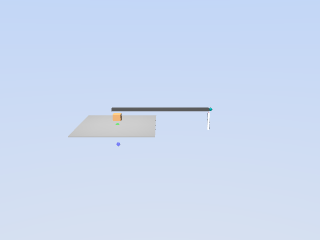

In [8]:
mujoco.mj_resetData(model_true, data_true)
mujoco.mj_forward(model_true, data_true)

with mujoco.Renderer(model_true) as renderer:
  renderer.update_scene(data_true)

  media.show_image(renderer.render())

In [9]:
data_true.body('base').xpos, data_true.body('payload').xpos, 

(array([0.  , 0.  , 0.54]), array([ 2.384 , -0.01  ,  0.8695]))

In [11]:
# define prediction
nf = 6
horizon = 80

#init mocap_pos for goal
mocap_pos = [1.5, 0.1, 0.7]
mocap_quat = [1, 0, 0, 0]

In [12]:
def generate_prediction(t):
    predict = []

    for i in range(horizon):
        dt = (i+1) * model_true.opt.timestep
        mp_action = [0.1* np.sin((t+dt) / np.pi * 1.5), 0 , 0, 0, 0, 0]  
        predict.extend(mp_action)
    return predict


In [13]:
# test userdata
userdata = generate_prediction(t=12)
print(userdata)
print(f"length of userdata: ",len(userdata))


[-0.05216917276436466, 0, 0, 0, 0, 0, -0.051761238142884525, 0, 0, 0, 0, 0, -0.051352123508915264, 0, 0, 0, 0, 0, -0.050941838189134316, 0, 0, 0, 0, 0, -0.050530391536907575, 0, 0, 0, 0, 0, -0.050117792932076244, 0, 0, 0, 0, 0, -0.04970405178074269, 0, 0, 0, 0, 0, -0.04928917751505619, 0, 0, 0, 0, 0, -0.0488731795929979, 0, 0, 0, 0, 0, -0.04845606749816522, 0, 0, 0, 0, 0, -0.048037850739555604, 0, 0, 0, 0, 0, -0.04761853885134968, 0, 0, 0, 0, 0, -0.047198141392694154, 0, 0, 0, 0, 0, -0.046776667947483724, 0, 0, 0, 0, 0, -0.04635412812414244, 0, 0, 0, 0, 0, -0.04593053155540479, 0, 0, 0, 0, 0, -0.04550588789809646, 0, 0, 0, 0, 0, -0.045080206832913305, 0, 0, 0, 0, 0, -0.044653498064201796, 0, 0, 0, 0, 0, -0.04422577131973659, 0, 0, 0, 0, 0, -0.04379703635049981, 0, 0, 0, 0, 0, -0.04336730293045826, 0, 0, 0, 0, 0, -0.042936580856340466, 0, 0, 0, 0, 0, -0.04250487994741361, 0, 0, 0, 0, 0, -0.04207221004525957, 0, 0, 0, 0, 0, -0.04163858101355053, 0, 0, 0, 0, 0, -0.041204002737824395, 0, 0

In [14]:

# initialize mjpc agent
reset_model_data()

actual_trajectory = []
plan_time = []
costs = []
cost_terms = []


agent.reset()

# lauch passive viewer
with mujoco.viewer.launch_passive(model_true, data_true) as viewer:

  # Close the passive viewer automatically after the defined wall-seconds.
  start = time.time()
  switch_time = time.time()

  while viewer.is_running() and time.time() - start < 120:

    # get current agent's state to update passive viewer
    current_state = agent.get_state()
    #print(current_state)
    
    # sync passive viewer data with agent state
    data_true.mocap_pos = mocap_pos
    #data_true.mocap_quat = current_state.mocap_quat
    data_true.time = current_state.time
    data_true.qpos = current_state.qpos
    data_true.qvel = current_state.qvel

    step_start = time.time()
    # step on the mjpc planner's side to get latest action
    for _ in range(5):
        agent.planner_step()
    plan_time.append(time.time() - step_start)

    agent_action = agent.get_action()

    # mask agent action to disable motion platform movement
    agent_action *= [1, 1, 1, 0, 0, 0, 0, 0, 0]

    # move motion platform according to known periodic signal
    t = time.time() - start
    agent_action[3] = 0.1* np.sin(t / np.pi *1.5 ) 

    # move passive viewer's crane and motion platform
    data_true.ctrl = agent_action
    
    # inject external perturbation via userdata
    #userdata = generate_prediction(t)
    userdata = np.zeros(model_true.nuserdata).tolist()

    # advance world physics (passive viewer) based on latest action by the planner
    mujoco.mj_step(model_true, data_true)
    
    actual_trajectory.append({
      'qpos': current_state.qpos,
      'qvel': current_state.qvel,
      'control': data_true.ctrl.copy(),
      'time': current_state.time,
      'payload_xpos': data_true.xpos[model_true.body('payload').id].copy()
    })

    viewer.sync()

    # set the current state from the agent from the world physics
    agent.set_state(
        time = data_true.time,
        qpos = data_true.qpos,
        qvel = data_true.qvel,
        mocap_pos = data_true.mocap_pos,
        userdata = userdata
    )  

    # update target position for planner's task
    new_goal_pos = agent.get_task_parameters()
    new_goal_pos['GoalX'] = mocap_pos[0]
    new_goal_pos['GoalY'] = mocap_pos[1]
    new_goal_pos['GoalZ'] = mocap_pos[2]
    agent.set_task_parameters(new_goal_pos)

    # tracking performance
    cost = agent.get_total_cost()
    costs.append(cost)

    cost_terms.append(agent.get_cost_term_values())

    #mean_time = np.asarray(plan_time).mean
    #print(cost)

    # move the target goal smoothly
    #mocap_pos[0] += 1.0 * np.cos(t / np.pi * 5 )
    #mocap_pos[1] += 1.0 * np.sin(t / np.pi * 5 )
    #mocap_pos[2] += 1.0 * np.cos(t / np.pi * 2 )

    # Rudimentary time keeping, will drift relative to wall clock.
    time_until_next_step = model_true.opt.timestep*2 - (time.time() - step_start)
    if time_until_next_step > 0:
      time.sleep(time_until_next_step)

agent.close()
costs = np.asarray(costs)
plan_time = np.asarray(plan_time)


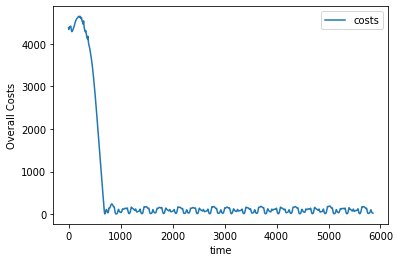

In [15]:
fig = plt.figure()
times = [i for i in range(len(costs))]
plt.plot(times, costs, label='costs')

plt.xlabel('time')
plt.ylabel('Overall Costs')

plt.legend()

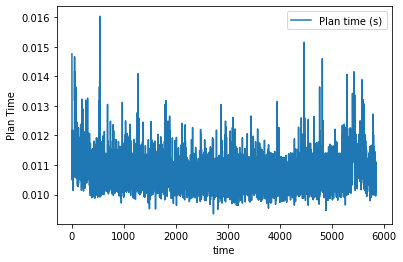

In [16]:
fig = plt.figure()
times = [i for i in range(len(plan_time))]
plt.plot(times, plan_time, label='Plan time (s)')

plt.xlabel('time')
plt.ylabel('Plan Time')

plt.legend()

In [17]:
xpos=[]
for i in range(len(actual_trajectory)):
    xpos.append(actual_trajectory[i]['payload_xpos'])

xpos = np.asarray(xpos)

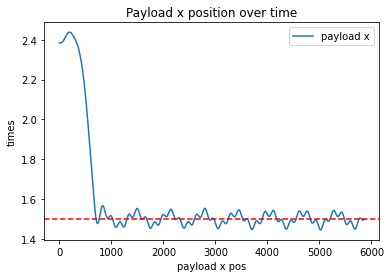

In [18]:
fig = plt.figure()
times = [i for i in range(len(actual_trajectory))]

plt.plot(times, xpos[:,0], label='payload x')
plt.axhline(y=mocap_pos[0], color='r', linestyle='--')

plt.xlabel('payload x pos')
plt.ylabel('times')
plt.title('Payload x position over time')


plt.legend()

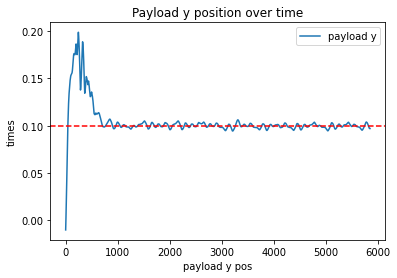

In [19]:
fig = plt.figure()
times = [i for i in range(len(actual_trajectory))]

plt.plot(times, xpos[:,1], label='payload y')
plt.axhline(y=mocap_pos[1], color='r', linestyle='--')

plt.xlabel('payload y pos')
plt.ylabel('times')
plt.title('Payload y position over time')

plt.legend()

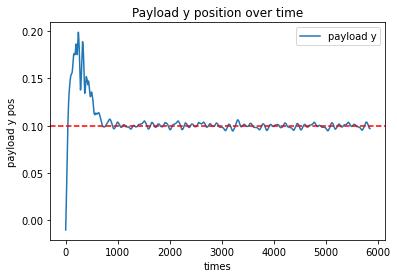

In [20]:
fig = plt.figure()
times = [i for i in range(len(actual_trajectory))]

plt.plot(times, xpos[:,1], label='payload y')
plt.axhline(y=mocap_pos[1], color='r', linestyle='--')

plt.ylabel('payload y pos')
plt.xlabel('times')
plt.title('Payload y position over time')

plt.legend()

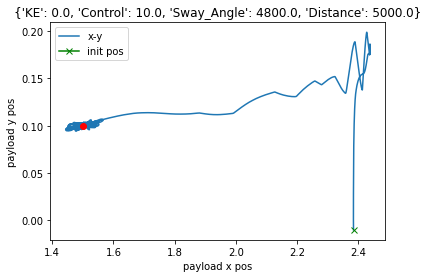

In [21]:
fig = plt.figure()
times = [i for i in range(len(actual_trajectory))]

plt.plot(xpos[:,0], xpos[:,1], label='x-y')
#plt.plot(true_ppos[:,0], true_ppos[:,1], label='disturbed gravity')
#plt.plot(corrected_ppos[:,0], corrected_ppos[:,1], linestyle='--', label='with force compensation')
plt.plot(mocap_pos[0], mocap_pos[1], color="red", marker="o")
plt.plot(xpos[0,0], xpos[0,1], color="green", marker="x", label='init pos')

plt.xlabel('payload x pos')
plt.ylabel('payload y pos')
plt.title( "{'KE': 0.0, 'Control': 10.0, 'Sway_Angle': 4800.0, 'Distance': 5000.0}")

plt.legend()

In [20]:
for i in range(len(cost_terms)):
    print(cost_terms[i])
#    xpos.append(actual_trajectory[i]['payload_xpos'])

#xpos = np.asarray(xpos)

{'Control': 0.03461487011484701, 'Distance': 0.8548171992820764, 'Sway_Angle': 0.024175988473331224, 'KE': 206.0192689067028}
{'Control': 0.04171181054836784, 'Distance': 0.856119425633203, 'Sway_Angle': 0.01997200027947757, 'KE': 187.1757432373306}
{'Control': 0.04420229942651943, 'Distance': 0.8575502320148767, 'Sway_Angle': 0.015681721572508835, 'KE': 169.85134709182412}
{'Control': 0.043951382489269, 'Distance': 0.8590794382738932, 'Sway_Angle': 0.012216888056136778, 'KE': 153.58792628412237}
{'Control': 0.043692916087412215, 'Distance': 0.8606747098784675, 'Sway_Angle': 0.00954711179259947, 'KE': 138.55235972935913}
{'Control': 0.04332462821729566, 'Distance': 0.8623036145859333, 'Sway_Angle': 0.00744216616073607, 'KE': 124.73763520846333}
{'Control': 0.04380537304605747, 'Distance': 0.8639352755589286, 'Sway_Angle': 0.005770166540640269, 'KE': 112.06064920408139}
{'Control': 0.043034188735108114, 'Distance': 0.8655453874172917, 'Sway_Angle': 0.004549210057591568, 'KE': 100.646230